In [1]:
import pandas as pd

# 데이터 불러오기
b_df = pd.read_csv('./datasets/bank.csv')

# 데이터 복사
pre_b_df = b_df.copy()

# 불필요한 컬럼 삭제하
pre_b_df = pre_b_df.drop(labels=['id', 'CustomerId'], axis=1).reset_index(drop=True)

# 타겟 데이터 설정하기
pre_b_df['target'] = pre_b_df['Exited']
pre_b_df = pre_b_df.drop(labels=['Exited'], axis=1)

# 타겟 데이터 비중 동일하게 조정 (언더샘플링)
zero = pre_b_df[pre_b_df.target == 0].sample(34921, random_state=124)
one = pre_b_df[pre_b_df.target == 1]

pre_b_df = pd.concat([zero, one])
pre_b_df.reset_index(drop=True, inplace=True)

In [2]:
from sklearn.preprocessing import LabelEncoder

# 문자열 컬럼 추출
columns = ['Surname', 'Geography', 'Gender']
label_encoders = {}

# 컬럼 반복하여 column에 담아 적용:
for column in columns:
    # LabelEncoder 객체 생성, 문자열 데이터 인코딩을 통해 정수로 형변환 후 데이터 교체
    encoder = LabelEncoder()
    # LabelEncoder를 사용하여 각 컬럼의 값을 변환
    result = encoder.fit_transform(pre_b_df[column])
    # 변환된 값의 클래스(고유한 값) 저장
    label_encoders[column] = encoder.classes_
    # 변환된 값 적용
    pre_b_df[column] = result

In [3]:
pre_b2_df = pre_b_df.copy()

In [4]:
# 수치형 데이터 이상치 제거
from sklearn.preprocessing import StandardScaler

std_pre_h_df = pre_b2_df.copy()
columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for column in columns:
    # 표준화 객체 생성
    std = StandardScaler()
    # 데이터 표준화 변환
    result = std.fit_transform(pre_b2_df[[column]])
    # 표준화 데이터 프레임 생성
    std_pre_h_df[column] = result

for column in columns:
    # 타겟 데이터 이상치 제거
    std_pre_h_df = std_pre_h_df[std_pre_h_df[column].between(-1.96, 1.96)]

# 이상치 제거 후 유지되는 인덱스를 대조하여 원본 데이터 이상치 제거
pre_b2_df = pre_b2_df.iloc[std_pre_h_df.index].reset_index(drop=True)

pre_b2_df

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,target
0,2474,584,2,0,34.0,9,123374.11,2,1.0,0.0,158935.83,0
1,1809,592,2,0,44.0,4,0.00,2,1.0,1.0,180696.44,0
2,1426,634,1,0,33.0,9,149349.58,2,0.0,0.0,137517.71,0
3,469,671,1,1,32.0,9,126606.63,2,1.0,0.0,126743.33,0
4,809,763,1,1,35.0,7,124551.66,2,0.0,1.0,47271.61,0
...,...,...,...,...,...,...,...,...,...,...,...,...
60061,413,543,1,0,43.0,9,134542.73,1,1.0,0.0,172363.52,1
60062,1052,576,1,0,26.0,4,114739.92,1,1.0,1.0,27654.64,1
60063,811,767,0,1,38.0,3,0.00,1,1.0,0.0,152872.84,1
60064,940,577,0,0,45.0,2,0.00,1,0.0,0.0,148811.14,1


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = pre_b2_df.iloc[:, :-1], pre_b2_df.iloc[:, -1]

# 문제/정답 및 훈련/테스트 데이터 분리 
X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, stratify=targets, random_state=124)

# 객체 생성
# solver: 최적화에 사용되는 알고리즘 (liblinear: 작은 데이터 세트 사용)
# penalty: 규제 유형 (l2 = L2 규제)
lg = LogisticRegression(solver='liblinear', penalty='l2', random_state=124)

# 훈련
lg.fit(X_train, y_train)

# 예측
prediction = lg.predict(X_test)

In [6]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_evaluation(y_test, prediction, classifier=None, X_test=None):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test , prediction)
    precision = precision_score(y_test , prediction)
    recall = recall_score(y_test , prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
    print("#" * 75)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

오차 행렬
[[4229 1857]
 [1833 4095]]
정확도: 0.6929, 정밀도: 0.6880, 재현율: 0.6908, F1:0.6894, AUC:0.6928
###########################################################################


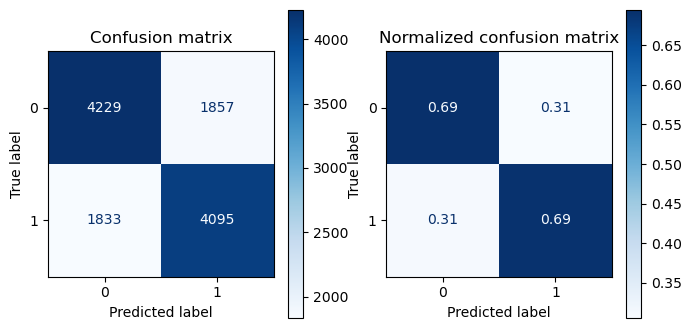

In [7]:
get_evaluation(y_test, prediction, lg, X_test)